In [289]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(729)

%load_ext autoreload
%autoreload 2

from brain import k_cap, idx_to_vec, FFArea, RecurrentArea, RandomChoiceArea, ScaffoldNetwork, FSMNetwork, PFANetwork, AttentionArea

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Forming an assembly

### Initialize a brain area

In [290]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.25
plasticity = 1e-1

In [291]:
brain_area = RecurrentArea(n_inputs, n_neurons, cap_size, density, plasticity)

In [292]:
stimulus = np.arange(cap_size)

### Form an assembly by presenting the stimulus several times

In [293]:
n_rounds = 10

activations = np.zeros((n_rounds, n_neurons))

brain_area.inhibit()
for i in range(n_rounds):
    brain_area.forward(stimulus)
    activations[i] = brain_area.read(dense=True)

### Plot activations during formation

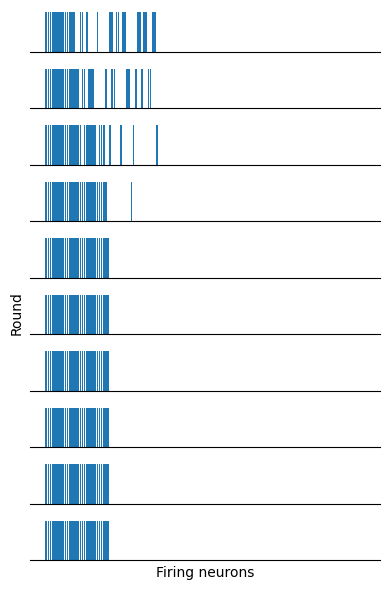

In [294]:
idx = activations.sum(axis=0).argsort()[::-1]

fig, axes = plt.subplots(n_rounds, figsize=(4, 6), sharex=True, sharey=True)

for i in range(n_rounds):
    axes[i].bar(np.arange(5*cap_size), activations[i, idx[:5 * cap_size]])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)

axes[n_rounds // 2].set_ylabel('Round')
axes[-1].set_xlabel('Firing neurons')
fig.tight_layout()

## Classifying stimulus classes

### Generate some samples from each stimulus class

In [295]:
n_classes = 3
n_samples_train = 10
n_samples_test = 200

class_vecs = np.full((n_classes, n_neurons), 0.5 * cap_size / n_neurons)
class_vecs[np.arange(n_classes)[:, np.newaxis], np.arange(n_classes * cap_size).reshape(n_classes, -1)] = 0.75

samples_train = rng.random((n_classes, n_samples_train, n_neurons)) < class_vecs[:, np.newaxis, :]
samples_test = rng.random((n_classes, n_samples_test, n_neurons)) < class_vecs[:, np.newaxis, :]

brain_area.reset()

### Visualize sample means

Text(0, 0.5, 'Fraction of firing')

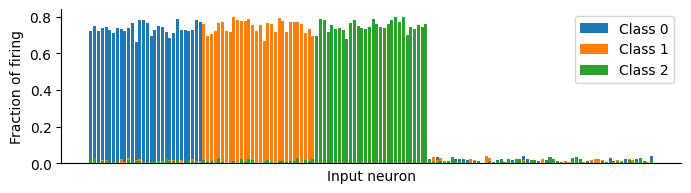

In [296]:
fig, ax = plt.subplots(figsize=(8, 2), sharex=True, sharey=True)
for i in range(n_classes):
    ax.bar(np.arange(5 * cap_size), samples_test[i].mean(axis=0)[:5*cap_size], label='Class {}'.format(i))
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_xlabel('Input neuron')
ax.set_ylabel('Fraction of firing')

In [297]:
assembly_support = np.zeros((n_classes, n_neurons))

for i in range(n_classes):
    brain_area.inhibit()
    for j in range(n_samples_train):
        brain_area.forward(np.nonzero(samples_train[i, j]))
    assembly_support[i] = brain_area.read(dense=True)

In [298]:
test_overlaps = np.zeros((n_classes, n_samples_test, n_classes))

for i in range(n_classes):
    for j in range(n_samples_test):
        brain_area.inhibit()
        brain_area.forward(np.nonzero(samples_test[i, j]), update=False)
        test_overlaps[i, j] = brain_area.read(dense=True) @ assembly_support.T

In [299]:
accuracy = np.mean(test_overlaps.argmax(axis=-1) == np.arange(n_classes)[:, np.newaxis], axis=-1)
for i in range(n_classes):
    print('Class {:d} accuracy: {:%}'.format(i, accuracy[i]))

Class 0 accuracy: 100.000000%
Class 1 accuracy: 100.000000%
Class 2 accuracy: 100.000000%


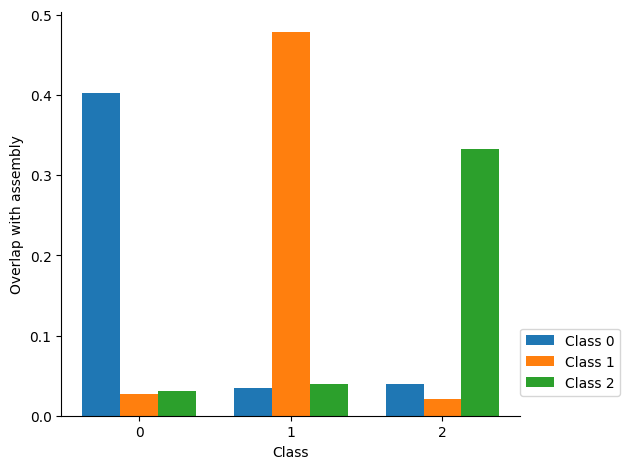

In [300]:
fig, ax = plt.subplots()
ax.bar(np.arange(n_classes)-0.25, test_overlaps[0].mean(axis=0) / cap_size, width=0.25, label='Class 0')
ax.bar(np.arange(n_classes), test_overlaps[1].mean(axis=0) / cap_size, width=0.25, label='Class 1')
ax.bar(np.arange(n_classes)+0.25, test_overlaps[2].mean(axis=0) / cap_size, width=0.25, label='Class 2')
ax.set_xticks(np.arange(n_classes))
ax.legend(loc=(1., 0.05))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Class')
ax.set_ylabel('Overlap with assembly')
fig.tight_layout()

## Memorizing sequences of inputs

### Initialize simple and scaffolded networks

In [301]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.4
plasticity = 1e-1

simple_seq_area = RecurrentArea(n_inputs, n_neurons, cap_size, density, plasticity)
scaff_seq_net = ScaffoldNetwork(n_inputs, n_neurons, cap_size, density, plasticity)

### Define a sequence of inputs

In [302]:
seq_len = 25
sequence = np.arange(seq_len * cap_size).reshape(seq_len, cap_size)

### Train the models by repeatedly presenting the sequence, testing recall after each presentation

In [303]:
n_presentations = 200

simple_seq_assemblies = np.zeros((seq_len, n_neurons))
scaff_seq_assemblies = np.zeros((seq_len, n_neurons))
simple_seq_recall = np.zeros((n_presentations, seq_len))
scaff_seq_recall = np.zeros((n_presentations, seq_len))
simple_seq_area.normalize()
scaff_seq_net.normalize()

for j in range(n_presentations):
    simple_seq_area.inhibit()
    scaff_seq_net.inhibit()
    for i in range(seq_len):
        simple_seq_area.forward(sequence[i])
        scaff_seq_net.forward(sequence[i])
        if j == 0:
            simple_seq_assemblies[i] = simple_seq_area.read(dense=True)
            scaff_seq_assemblies[i] = scaff_seq_net.read(dense=True)
    
    simple_seq_area.inhibit()
    scaff_seq_net.inhibit()
    simple_seq_area.normalize()
    scaff_seq_net.normalize()
    
    
    simple_seq_area.set_input(sequence[0])
    scaff_seq_net.set_input(sequence[0])
    for i in range(seq_len):
        simple_seq_area.step(update=False)
        scaff_seq_net.step(update=False)
        
        simple_seq_recall[j, i] = simple_seq_area.read(dense=True) @ simple_seq_assemblies[i]
        scaff_seq_recall[j, i] = scaff_seq_net.read(dense=True) @ scaff_seq_assemblies[i]

### Plot the results

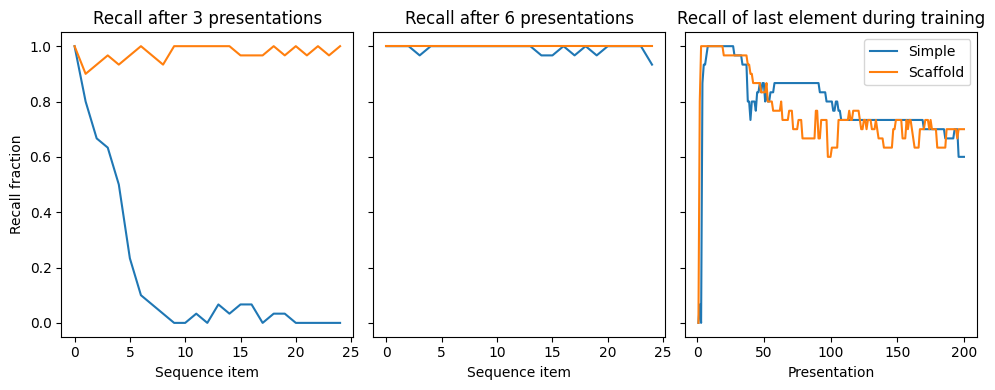

In [304]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axes[0].plot(np.arange(seq_len), simple_seq_recall[2] / cap_size)
axes[0].plot(np.arange(seq_len), scaff_seq_recall[2] / cap_size)
axes[0].set_title('Recall after 3 presentations')
axes[0].set_ylabel('Recall fraction')
axes[0].set_xlabel('Sequence item')

axes[1].plot(np.arange(seq_len), simple_seq_recall[5] / cap_size)
axes[1].plot(np.arange(seq_len), scaff_seq_recall[5] / cap_size)
axes[1].set_title('Recall after 6 presentations')
axes[1].set_xlabel('Sequence item')

axes[2].plot(np.arange(n_presentations)+1, simple_seq_recall[:, -1] / cap_size, label='Simple')
axes[2].plot(np.arange(n_presentations)+1, scaff_seq_recall[:, -1] / cap_size, label='Scaffold')
axes[2].set_title('Recall of last element during training')
axes[2].set_xlabel('Presentation')
axes[2].legend()

fig.tight_layout()

## Simulate a FSM (DFA) to recognize numbers divisible by 3

We will simulate the following FSM, which recognizes numbers divisible by 3. It does this by tracking the sum of the digits mod 3 and accepting if the result is 0.

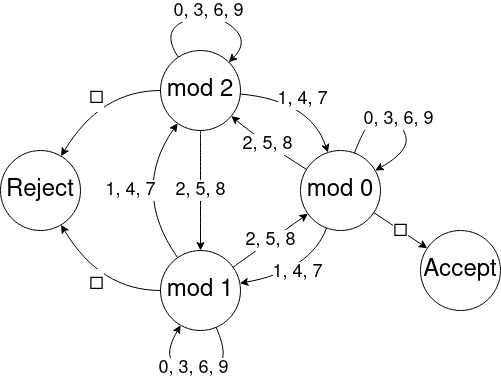

### Define a network to simulate the FSM

In [305]:
n_symbol_neurons = 1000
n_state_neurons = 500
n_arc_neurons = 5000
cap_size = 70
density = 0.2
plasticity = 1e-1

fsm_net = FSMNetwork(n_symbol_neurons, n_state_neurons, n_arc_neurons, cap_size, density, plasticity)

n_symbols = 10 + 1
n_states = 3 + 2

symbols = np.arange(n_symbols * cap_size).reshape(n_symbols, cap_size)
states = np.arange(n_states * cap_size).reshape(n_states, cap_size)

n_arcs = 11 * 3

### Define the FSM (via its transitions)

In [306]:
transition_list = []

for mod in range(3):
    for digit in range(10):
        transition_list += [[mod, digit, (mod + digit) % 3]]

transition_list += [[0, 10, 3], [1, 10, 4], [2, 10, 4]]

### Train the model by repeatedly presenting each transition

In [307]:
n_presentations = 200

arcs = np.zeros((len(transition_list), cap_size), dtype=int)

for i in range(n_presentations):
    for j, transition in enumerate(transition_list):
        fsm_net.train(symbols[transition[1]], states[transition[0]], states[transition[2]])
        arcs[j] = fsm_net.arc_area.read()

state_overlaps = np.zeros((len(transition_list), n_states))
for i, transition in enumerate(transition_list):
    fsm_net.inhibit()
    fsm_net.arc_area.forward([symbols[transition[1]], states[transition[0]]], update=False)
    fsm_net.state_area.forward(fsm_net.arc_area.read(), update=False)
    state_overlaps[i] = idx_to_vec(states, n_state_neurons) @ fsm_net.read(dense=True)

### Test the model by presenting a string of digits

In [308]:
# positive example
sequence = [3, 0, 4, 7, 1, 10]
# negative example
# sequence = [6, 7, 3, 10]

outputs = np.zeros((len(sequence)+1, n_state_neurons))
fsm_net.state_area.fire(states[0], update=False)
outputs[0] = fsm_net.read(dense=True)
for i in range(len(sequence)):
    fsm_net.forward(symbols[sequence[i]], update=False)
    outputs[i+1] = fsm_net.read(dense=True)

### Plot the result

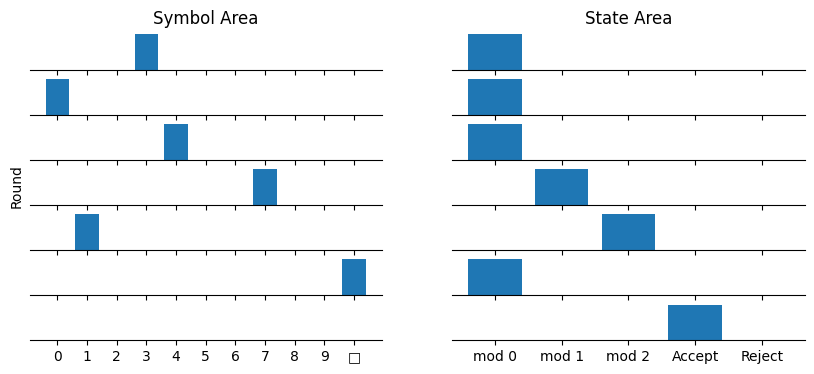

In [309]:
symbol_overlaps = np.zeros((len(sequence)+1, n_symbols))
symbol_overlaps[np.arange(len(sequence)), sequence] = 1.

state_overlaps = outputs @ idx_to_vec(states, n_state_neurons).T / cap_size

fig, axes = plt.subplots(len(sequence)+1, 2, figsize=(10, 4), sharey=True)
for i in range(len(sequence) + 1):
    axes[i, 0].bar(np.arange(n_symbols), symbol_overlaps[i])
    axes[i, 1].bar(np.arange(n_states), state_overlaps[i])
    axes[i, 0].set_xticks(np.arange(n_symbols))
    axes[i, 1].set_xticks(np.arange(n_states))
    
axes[-1, 0].set_xticklabels([i for i in range(n_symbols-1)] + ['□'])
axes[-1, 1].set_xticklabels(['mod 0', 'mod 1', 'mod 2', 'Accept', 'Reject'])

axes[len(sequence) // 2, 0].set_ylabel('Round')
axes[0, 0].set_title('Symbol Area')
axes[0, 1].set_title('State Area')
    
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

Overall mean accuracy across lengths 1-50: 1.000
Mean accuracy for lengths 1-10: 1.000
Per-length accuracies (1-10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


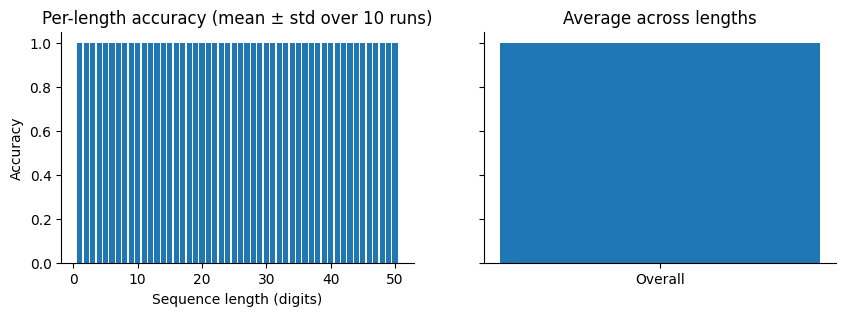

In [310]:
# Evaluate DFA accuracy over random digit sequences
n_trials_per_len = 10
max_len = 50  # maximum number of digits before the blank symbol (10)
lengths = np.arange(1, max_len + 1)

per_len_results = np.zeros((max_len, n_trials_per_len), dtype=float)

# Reconstruct the DFA assemblies in case later sections overwrote `symbols` or `states`
dfa_symbols = np.arange((10 + 1) * cap_size).reshape(10 + 1, cap_size)
dfa_states = np.arange((3 + 2) * cap_size).reshape(3 + 2, cap_size)
state_basis = idx_to_vec(dfa_states, n_state_neurons)

for i, L in enumerate(lengths):
    for t in range(n_trials_per_len):
        digits = rng.integers(0, 10, size=L)
        gt_accept = (digits.sum() % 3 == 0)
        seq = list(digits) + [10]  # append blank to trigger accept/reject

        fsm_net.inhibit()
        fsm_net.state_area.fire(dfa_states[0], update=False)

        # Process each symbol exactly once; the network has a single update per input.
        for symbol_idx in seq:
            fsm_net.forward(dfa_symbols[symbol_idx], update=False)

        final_dense = fsm_net.read(dense=True)
        final_overlap = final_dense @ state_basis.T / cap_size
        pred_state = int(np.argmax(final_overlap))
        pred_accept = (pred_state == 3)  # indices: [mod0, mod1, mod2, Accept, Reject]

        per_len_results[i, t] = int(pred_accept == gt_accept)

per_len_acc = per_len_results.mean(axis=1)
per_len_std = per_len_results.std(axis=1)
overall_acc = per_len_acc.mean()

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax[0].bar(lengths, per_len_acc, capsize=3)
ax[0].set_xlabel('Sequence length (digits)')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1.05)
ax[0].set_title(f'Per-length accuracy (mean ± std over {n_trials_per_len} runs)')

ax[1].bar([0], [overall_acc], width=0.6)
ax[1].set_xticks([0])
ax[1].set_xticklabels(['Overall'])
ax[1].set_ylim(0, 1.05)
ax[1].set_title('Average across lengths')

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

print(f'Overall mean accuracy across lengths 1-{max_len}: {overall_acc:.3f}')
if max_len >= 10:
    first_10_mean = per_len_acc[:10].mean()
    print(f'Mean accuracy for lengths 1-10: {first_10_mean:.3f}')
    print('Per-length accuracies (1-10):', np.round(per_len_acc[:10], 3))

## Simulate a PFA to generate simple sentences

We will train a NEMO network to simulate the following PFA, which generates sentences like "the boy throws a ball", "a dog catches the ball", ....

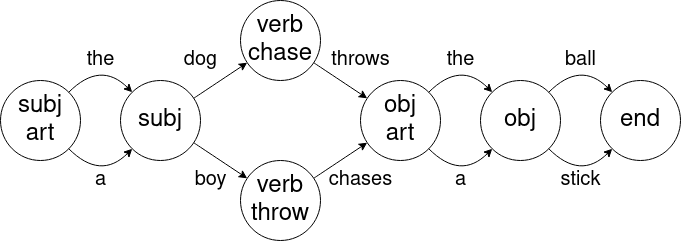

### Define a network of brain areas

In [311]:
n_symbol_neurons = 1000
n_state_neurons = 500
n_arc_neurons = 5000
n_random_neurons = 1000
cap_size = 70
density = 0.25
plasticity = 0.1

pfa_net = PFANetwork(n_symbol_neurons, n_state_neurons, n_arc_neurons, n_random_neurons, cap_size, density, plasticity)

### Define the PFA (via its transitions)

In [312]:
lexicon = np.array(['the', 'a', 'boy', 'dog', 'throws', 'chases', 'ball', 'stick'])

transition_list = [[0, 0, 1, 0], [0, 1, 1, 1], # subject article
                   [1, 0, 2, 2], [1, 1, 3, 3], # subject
                   [2, 0, 4, 4], [2, 1, 4, 4], # verb throws
                   [3, 0, 4, 5], [3, 1, 4, 5], # verb chases
                   [4, 0, 5, 0], [4, 1, 5, 1], # object article
                   [5, 0, 6, 6], [5, 1, 6, 7]] # object

In [313]:
n_states = 7
n_symbols = len(lexicon)
n_arcs = len(transition_list)

In [314]:
states = np.arange(n_states * cap_size).reshape(n_states, cap_size)
symbols = np.arange(n_symbols * cap_size).reshape(n_symbols, cap_size)

### Train the model by repeatedly presenting each transition

In [315]:
n_presentations = 15

for i in range(n_presentations):
    for j, transition in enumerate(transition_list):
        pfa_net.train(states[transition[0]], transition[1], states[transition[2]], symbols[transition[3]])

### Sample from the model

In [316]:
n_trials = 10

symbol_outputs = np.zeros((n_trials, 5, n_symbol_neurons))
state_outputs = np.zeros((n_trials, 5, n_state_neurons))

for i in range(n_trials):
    pfa_net.state_area.fire(states[0])
    for j in range(5):
        pfa_net.step()
        symbol_outputs[i, j] = pfa_net.read(dense=True)
        state_outputs[i, j] = pfa_net.state_area.read(dense=True)

In [317]:
symbol_overlaps = symbol_outputs[:, :, :cap_size*n_symbols].reshape(n_trials, 5, n_symbols, cap_size).sum(axis=-1)
state_overlaps = state_outputs[:, :, :cap_size*n_states].reshape(n_trials, 5, n_states, cap_size).sum(axis=-1)

In [318]:
output_symbols = lexicon[symbol_overlaps.argmax(axis=-1)]

In [319]:
output_symbols

array([['a', 'boy', 'throws', 'a', 'stick'],
       ['the', 'boy', 'throws', 'a', 'stick'],
       ['the', 'boy', 'throws', 'a', 'stick'],
       ['a', 'dog', 'chases', 'the', 'ball'],
       ['a', 'dog', 'chases', 'a', 'ball'],
       ['the', 'boy', 'throws', 'a', 'stick'],
       ['a', 'boy', 'throws', 'the', 'stick'],
       ['the', 'dog', 'chases', 'a', 'stick'],
       ['a', 'dog', 'chases', 'a', 'stick'],
       ['the', 'ball', 'stick', 'throws', 'the']], dtype='<U6')

### Plot the activations for one sample

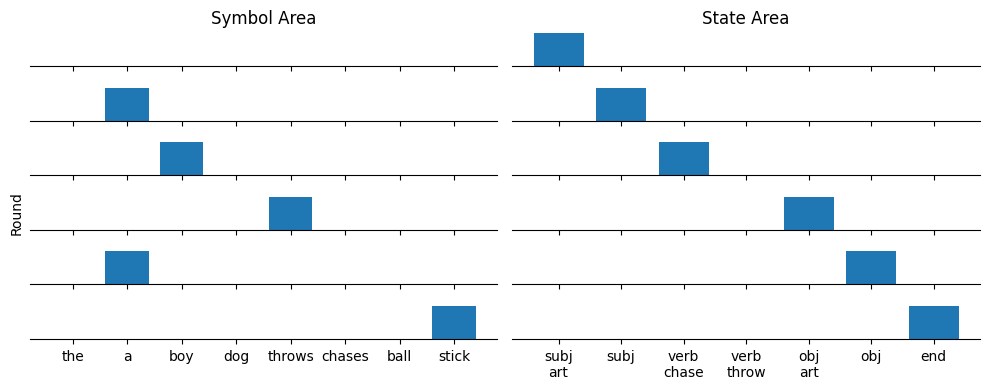

In [320]:
trial = 0

fig, axes = plt.subplots(6, 2, figsize=(10, 4), sharey=True)
axes[0, 0].bar(np.arange(n_symbols), np.zeros(n_symbols))
axes[0, 1].bar(np.arange(n_states), [cap_size, 0, 0, 0, 0, 0, 0])
axes[0, 0].set_xticks(np.arange(n_symbols))
axes[0, 1].set_xticks(np.arange(n_states))

for i in range(5):
    axes[i+1, 0].bar(np.arange(n_symbols), symbol_overlaps[trial, i])
    axes[i+1, 1].bar(np.arange(n_states), state_overlaps[trial, i])
    axes[i+1, 0].set_xticks(np.arange(n_symbols))
    axes[i+1, 1].set_xticks(np.arange(n_states))
    

for ax in axes:
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    
axes[-1, 0].set_xticklabels(lexicon)
axes[-1, 1].set_xticklabels(['subj\nart', 'subj', 'verb\nchase', 'verb\nthrow', 'obj\nart', 'obj', 'end'])

axes[6 // 2, 0].set_ylabel('Round')
axes[0, 0].set_title('Symbol Area')
axes[0, 1].set_title('State Area')
    
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    
fig.tight_layout()

In [321]:
from scipy.sparse import csc_array, csr_array
from nemo import k_cap, idx_to_vec, random_sparse_array, random_block_array

## Estimate & simulate a Markov chain

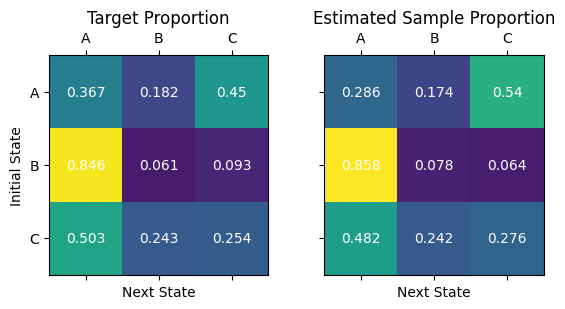

In [322]:
cap_size = 500
input_cap_size = cap_size
n_inputs = 3000
n_neurons = 20 * cap_size
density = 0.1
norm_m = int(2 * input_cap_size * density)

n_states = 3
distribution = rng.exponential(scale = 1., size=(n_states, n_states))
distribution /= distribution.sum(axis=-1, keepdims=True)

arc_inp_w = random_sparse_array(n_inputs, n_neurons, density)
arc_rec_w = random_block_array(np.eye(n_neurons // cap_size) > 0, cap_size, cap_size, density)

state_assm_idx = np.arange(n_states * input_cap_size).reshape(n_states, -1)
arc_assm_idx = np.arange(n_states * cap_size).reshape(n_states, -1)

for i in range(n_states):
    idx = np.ix_(arc_assm_idx[i], arc_assm_idx[i])
    arc_rec_w[idx] *= 10

lam = 24
beta = 1000
def get_weight(n_rounds, exact=True):
    if exact:
        if n_rounds == 0:
            return 1
        w = 1 + np.log(beta * lam) / lam
        for i in range(n_rounds-1):
            w += beta * np.exp(-lam * (w-1))
        return w
    else:
        return 1 + np.maximum(np.log(beta * lam * n_rounds) / lam, 0)

empirical_count = np.round(distribution * 100).astype(int)

for i in range(n_states):
    for j in range(n_states):
        idx = np.ix_(state_assm_idx[i], arc_assm_idx[j])
        arc_inp_w[idx] *= get_weight(empirical_count[i,j])

n_rounds = 10
n_samples = 500

actual_counts = np.zeros((n_states, n_states))

noise = 5.
for i in range(n_states):
    activated = np.zeros((n_samples, n_rounds, cap_size), dtype=int)

    randomness = noise * np.sqrt(cap_size * density) * rng.standard_normal((n_samples, n_neurons))
    
    activated[:, 0] = k_cap(arc_inp_w[state_assm_idx[i]].sum(axis=0) + randomness, cap_size)
    for j in range(n_rounds-1):
        act_array = csr_array((np.ones(cap_size * n_samples), activated[:, j, :].reshape(-1), np.arange(0, n_samples*cap_size+1, cap_size)), shape=(n_samples, n_neurons))
        activated[:, j+1] = k_cap((act_array @ arc_rec_w).toarray(), cap_size)
        
    dense_act = idx_to_vec(activated, n_neurons)

    overlaps = dense_act[:, :, arc_assm_idx.reshape(-1)].reshape(n_samples, n_rounds, n_states, cap_size).sum(axis=-1)

    actual_counts[i] = (overlaps[:, -1] > 0.8 * cap_size).sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
axes[0].matshow(distribution, vmin=0, vmax=max(distribution.max(), actual_counts.max()/ n_samples))
axes[0].set_title('Target Proportion')
for i in range(n_states):
    for j in range(n_states):
        axes[0].text(j, i, np.round(distribution[i, j], 3), ha='center', va='center', color='w')
axes[1].matshow(actual_counts / n_samples, vmin=0, vmax=max(distribution.max(), actual_counts.max()/ n_samples))
axes[1].set_title('Estimated Sample Proportion')
for i in range(n_states):
    for j in range(n_states):
        axes[1].text(j, i, actual_counts[i,j]/n_samples, ha='center', va='center', color='w')
for ax in axes:
    ax.set_xticks(np.arange(n_states))
    ax.set_xticklabels(['A', 'B', 'C', 'D', 'E'][:n_states])
    ax.set_xlabel('Next State')
axes[0].set_yticks(np.arange(n_states))    
axes[0].set_yticklabels(['A', 'B', 'C', 'D', 'E'][:n_states])
axes[0].set_ylabel('Initial State')
fig.tight_layout()

## Estimate & simulate a trigram model

### Define the corpus

In [323]:
v1 = 'The Owl and the Pussycat went to sea In a beautiful pea-green boat. They took some honey, and plenty of money, Wrapped up in a five-pound note. The Owl looked up to the stars above, And sang to a small guitar,'
v2 = 'You elegant fowl! How charmingly sweet you sing! O let us be married! too long we have tarried: But what shall we do for a ring? They sailed away, for a year and a day, To the land where the Bong-Tree grows And there in a wood a Piggy-wig stood With a ring at the end of his nose.'
v3 = 'Dear Pig, are you willing to sell for one shilling Your ring? Said the Piggy, I will. So they took it away, and were married next day By the Turkey who lives on the hill. They dined on mince, and slices of quince, Which they ate with a runcible spoon; And hand in hand, on the edge of the sand, They danced by the moon. □ □ □'

def clean(s):
    return ' '.join(s.split()).lower().translate({ord(c) : ' .' for c in '.?!;'} | {ord(c) : None for c in ',:"'} | {ord('-') : ' ', ord('\n') : ''})

corpus = [clean(s) for s in [v1 + ' ' + v2 + ' ' + v3]]
corpus

['the owl and the pussycat went to sea in a beautiful pea green boat . they took some honey and plenty of money wrapped up in a five pound note . the owl looked up to the stars above and sang to a small guitar you elegant fowl . how charmingly sweet you sing . o let us be married . too long we have tarried but what shall we do for a ring . they sailed away for a year and a day to the land where the bong tree grows and there in a wood a piggy wig stood with a ring at the end of his nose . dear pig are you willing to sell for one shilling your ring . said the piggy i will . so they took it away and were married next day by the turkey who lives on the hill . they dined on mince and slices of quince which they ate with a runcible spoon . and hand in hand on the edge of the sand they danced by the moon . □ □ □']

### Define the model

In [324]:
cap_size = 500
density = 0.1

lexicon = list(set([token for s in corpus for token in s.split()]))
sequences = [[lexicon.index(token) for token in s.split()] for s in corpus]
trigram_seq = [(seq[i], seq[i+1], seq[i+2]) for seq in sequences for i in range(len(seq)-2)]
trigrams = list(set(trigram_seq))
trigram_count = [trigram_seq.count(gram) for gram in trigrams]
n_words = len(lexicon)
n_trigrams = len(trigrams)

density = 0.1
word_cap_size = 500

n_word_neurons = n_words * word_cap_size

first_word_graph = np.zeros((n_words, n_words), dtype=bool)
second_word_graph = np.zeros((n_words, n_words), dtype=bool)
for i, trigram in enumerate(trigrams):
    first_word_graph[trigram[0], trigram[2]] = True
    second_word_graph[trigram[1], trigram[2]] = True


trans_inp_ws = [random_block_array(first_word_graph, word_cap_size, word_cap_size, density), 
                random_block_array(second_word_graph, word_cap_size, word_cap_size, density)]
trans_rec_w = random_block_array(np.eye(n_words) > 0, word_cap_size, word_cap_size, density)

word_assm_idx = np.arange(n_word_neurons).reshape(n_words, word_cap_size)

### Train the model by presenting the corpus 5 times

In [325]:
n_presentations = 5

lam = 60
beta = 0.5
def get_weight(n_rounds, exact=True):
    if exact:
        if n_rounds == 0:
            return 1
        w = 1 + beta + np.log(lam) / lam
        for i in range(n_rounds-1):
            w += np.exp(lam * (1 + beta - w))
        return w
    else:
        return 1 + np.maximum(beta + np.log(lam * n_rounds) / lam, 0)

for i in range(n_trigrams):
    for j in range(2):
        trans_inp_ws[j][np.ix_(word_assm_idx[trigrams[i][j]], word_assm_idx[trigrams[i][-1]])] *= get_weight(n_presentations * trigram_count[i])

### Sample from the model

In [326]:
n_rounds = 10
word1 = 'the'
word2 = 'owl'
seq_len = 100
noise = 10.

activated = np.zeros((seq_len, word_cap_size), dtype=int)
activated[0] = word_assm_idx[lexicon.index(word1)]
activated[1] = word_assm_idx[lexicon.index(word2)]
for i in range(seq_len-2):
    temp_act = np.zeros((n_rounds, word_cap_size), dtype=int)
    
    randomness = noise * np.sqrt(word_cap_size * density) * rng.standard_normal(n_word_neurons)
    temp_act[0] = k_cap(np.sum([w[activated[i+j]].sum(axis=0) for j, w in enumerate(trans_inp_ws)], axis=0) + randomness, word_cap_size)
    for j in range(n_rounds-1):
        temp_act[j+1] = k_cap(trans_rec_w[temp_act[j]].sum(axis=0), word_cap_size)

    activated[i+2] = temp_act[-1]

dense_act = idx_to_vec(activated, n_word_neurons)
overlaps = dense_act.reshape(seq_len, n_words, word_cap_size).sum(axis=-1)
sampled_seq = overlaps.argmax(axis=-1)
' '.join([lexicon[i] for i in sampled_seq]).replace(' .', '.')

'the owl and the pussycat went to sea in a five pound note. they took it away and a day to the land where the bong tree grows and there in a beautiful pea green boat. they took it away and a day to the land where the bong tree grows and there in a beautiful pea green boat. they took it away and a day to the land where the bong tree grows and there in a five pound note. they took it away and a day to the stars above and sang to a'

## Solve analogies using attention

### Define a dictionary of words
Each word has a category and a property; analogies consist of memorizing ordered pairs of categories or properties

In [327]:
word_defs = {'king': ['RULER', 'MASC'],
             'queen': ['RULER', 'FEM'],
             'monarch': ['RULER', 'NEUT'],
             'man': ['HUMAN', 'MASC'],
             'woman': ['HUMAN', 'FEM'],
             'person': ['HUMAN', 'NEUT'],
             'hand': ['ARM', 'EXTREMITY'],
             'foot': ['LEG', 'EXTREMITY'],
             'finger': ['ARM', 'DIGIT'],
             'toe': ['LEG', 'DIGIT'],
             'rock': ['SUBSTANCE', 'HARD'],
             'sand': ['SUBSTANCE', 'DRY'],
             'water': ['SUBSTANCE', 'WET'],
             'ice': ['SUBSTANCE', 'FROZEN'],
             'mountain': ['LANDSCAPE', 'HARD'],
             'desert': ['LANDSCAPE', 'DRY'],
             'ocean': ['LANDSCAPE', 'WET'],
             'tundra': ['LANDSCAPE', 'FROZEN'],
             'eye': ['ORGAN', 'SIGHT'],
             'ear': ['ORGAN', 'SOUND'],
             'nose': ['ORGAN', 'SMELL'],
             'tongue': ['ORGAN', 'TASTE'],
             'vision': ['PERCEPT', 'SIGHT'],
             'hearing': ['PERCEPT', 'SOUND'],
             'smell': ['PERCEPT', 'SMELL'],
             'taste': ['PERCEPT', 'TASTE']}

lexicon = list(word_defs.keys())
categories = list(set([word_defs[w][0] for w in lexicon]))
properties = list(set([word_defs[w][1] for w in lexicon]))

word_encs = dict([(w, [categories.index(word_defs[w][0]), properties.index(word_defs[w][1])]) for w in lexicon])

### Initialize a network with attention
The word area contains a representation of each word, and is bi-directionally connected with the category and property areas (so that word assemblies link to their respective categories and properties and vice versa). Category and properties areas have recurrent short-term plasticity, which functions like attention. Here, it links sequences of firing assemblies together temporarily.

In [328]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.5
plasticity = 2

In [329]:
word_assm_idx = k_cap(rng.random(size=(len(lexicon), n_neurons)), cap_size)
cat_assm_idx = k_cap(rng.random(size=(len(categories), n_neurons)), cap_size)
prop_assm_idx = k_cap(rng.random(size=(len(properties), n_neurons)), cap_size)

In [330]:
word_area = FFArea([n_neurons]*2, n_neurons, cap_size, density, plasticity)
cat_area = AttentionArea(n_neurons, n_neurons, cap_size, density, plasticity)
prop_area = AttentionArea(n_neurons, n_neurons, cap_size, density, plasticity)

for i in range(len(categories)):
    cat_area.set_recurrent_weights(cat_assm_idx[i], cat_assm_idx[i], 2)

for i in range(len(properties)):
    prop_area.set_recurrent_weights(prop_assm_idx[i], prop_assm_idx[i], 2)

for i in range(len(lexicon)):
    cat_area.set_input_weights(word_assm_idx[i], cat_assm_idx[word_encs[lexicon[i]][0]], 4)
    prop_area.set_input_weights(word_assm_idx[i], prop_assm_idx[word_encs[lexicon[i]][1]], 4)
    word_area.set_input_weights(cat_assm_idx[word_encs[lexicon[i]][0]], word_assm_idx[i], 2, area=0)
    word_area.set_input_weights(prop_assm_idx[word_encs[lexicon[i]][1]], word_assm_idx[i], 2, area=1)

### Input an analogy problem

In [331]:
## change me!
input = 'hand:foot::finger:'

### Solve the analogy using the network

In [332]:
example = input.split(':')[:2]
prompt = input.split(':')[3]

### Feed the first token
cat_area.forward(word_assm_idx[lexicon.index(example[0])])
prop_area.forward(word_assm_idx[lexicon.index(example[0])])

### Feed the second token
cat_area.forward(word_assm_idx[lexicon.index(example[1])])
prop_area.forward(word_assm_idx[lexicon.index(example[1])])

### Silence the network
cat_area.inhibit()
prop_area.inhibit()

### Feed the third token
cat_area.forward(word_assm_idx[lexicon.index(prompt)])
prop_area.forward(word_assm_idx[lexicon.index(prompt)])

### Predict the attributes of the final token
cat_area.step(update=False)
prop_area.step(update=False)
cat_pred = categories[(idx_to_vec(cat_assm_idx, n_neurons) @ cat_area.read(dense=True)).argmax()]
prop_pred = properties[(idx_to_vec(prop_assm_idx, n_neurons) @ prop_area.read(dense=True)).argmax()]

### Map the attributes to a word
word_area.forward([cat_area.read(), prop_area.read()], update=False)
response = lexicon[(idx_to_vec(word_assm_idx, n_neurons) @ word_area.read(dense=True)).argmax()]

### Reset everything
cat_area.decay_weights()
cat_area.inhibit()
prop_area.decay_weights()
prop_area.inhibit()
word_area.inhibit()

In [333]:
[response, cat_pred, prop_pred]

['toe', 'LEG', 'DIGIT']